# Setup

Given a random baseball team, we wish to predict whether that team will win the world series. We do not include teams which did not make the playoffs, though this is an interesting idea and probably much harder/noisier. We will use a number of different models to see which performs better. 

In [1]:
import warnings; warnings.filterwarnings("ignore") # hide Python warnings 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from dplython import (DplyFrame, X, diamonds, select, sift, sample_n,
    sample_frac, head, arrange, mutate, group_by, summarize, DelayFunction) 
from plotnine import *
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

## The data

In [2]:
teams = pd.read_csv('https://raw.githubusercontent.com/chadwickbureau/baseballdatabank/master/core/Teams.csv')
teams.columns

Index(['yearID', 'lgID', 'teamID', 'franchID', 'divID', 'Rank', 'G', 'Ghome',
       'W', 'L', 'DivWin', 'WCWin', 'LgWin', 'WSWin', 'R', 'AB', 'H', '2B',
       '3B', 'HR', 'BB', 'SO', 'SB', 'CS', 'HBP', 'SF', 'RA', 'ER', 'ERA',
       'CG', 'SHO', 'SV', 'IPouts', 'HA', 'HRA', 'BBA', 'SOA', 'E', 'DP', 'FP',
       'name', 'park', 'attendance', 'BPF', 'PPF', 'teamIDBR',
       'teamIDlahman45', 'teamIDretro'],
      dtype='object')

In [3]:
# Filtering out seasons before 1970
teams = teams[teams['yearID']>=1970]

# Filtering out teams that did not make it to the playoffs.
teams = teams[(teams['DivWin']=="Y") | (teams['WCWin']=="Y")]

# useless columns to drop
dropped_cols = ['Rank','G','Ghome','teamIDBR','teamIDlahman45','teamIDretro','DivWin','WCWin',
       'LgWin','name','park']

teams = teams.drop(dropped_cols, axis=1)
# Replace Y and N with 1 and 0
# teams.WSWin = teams.WSWin.replace(to_replace=['N','Y'], value=[0,1])
oldteams = teams.copy()

We filter out all teams before 1969, since this is when the playoffs started. The 1969 teams have some missing values so we remove that year as well and start at 1970. We also remove useless variables and create a second copy of the teams data called oldteams, which we will use to determine if we want to use the team names as predictors. Below we add more stats, like the number of plate appearances, on base %, slugging %, "total bases", and the rate at which a team gets singles, doubles, etc per plate appearance.

In [4]:
# Adding stats like OBP, OPS, etc
teams['PA'] = teams['AB'] + teams['BB'] + teams['HBP']
teams['OBP'] = (teams['H'] + teams['BB']+teams['HBP']) / teams['PA']
teams['TB'] = teams['H'] + teams['2B'] + 2*teams['3B'] + 3*teams['HR'] 
teams['SLG'] = teams['TB']/teams['AB']
teams['OPS'] = teams['SLG'] + teams['OBP']
teams['hit_rate'] = teams['H'] / teams['PA']
teams['sing_rate'] = (teams['H']-teams['2B']- teams['3B']-teams['HR'])/teams['PA']
teams['doub_rate'] = teams['2B']/teams['PA']
teams['trip_rate'] = teams['3B']/teams['PA']
teams['dong_rate'] = teams['HR']/teams['PA']
teams['walk_rate'] = teams['BB']/teams['PA']
teams['hbp_rate'] = teams['HBP']/teams['PA']

In [5]:
teams.columns

# Replace categorical variables with dummy 0/1 variables/vectors
#teams = pd.get_dummies(teams)

Index(['yearID', 'lgID', 'teamID', 'franchID', 'divID', 'W', 'L', 'WSWin', 'R',
       'AB', 'H', '2B', '3B', 'HR', 'BB', 'SO', 'SB', 'CS', 'HBP', 'SF', 'RA',
       'ER', 'ERA', 'CG', 'SHO', 'SV', 'IPouts', 'HA', 'HRA', 'BBA', 'SOA',
       'E', 'DP', 'FP', 'attendance', 'BPF', 'PPF', 'PA', 'OBP', 'TB', 'SLG',
       'OPS', 'hit_rate', 'sing_rate', 'doub_rate', 'trip_rate', 'dong_rate',
       'walk_rate', 'hbp_rate'],
      dtype='object')

We plot, for example, Total bases vs ERA and see if there appears to be any relation between World series wins and these variables.

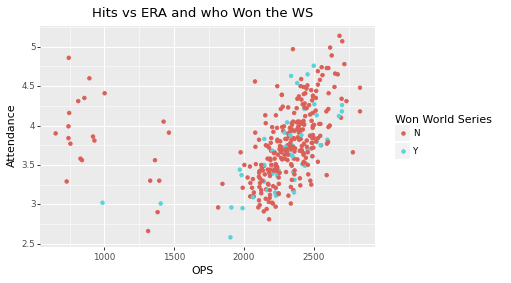

<ggplot: (8736349998264)>

In [6]:
(
    ggplot(teams)
    + aes(x="TB", y="ERA", color="WSWin", )
    + labs(
        x = "OPS",
        y = "Attendance",
        color="Won World Series",
        title="Hits vs ERA and who Won the WS",
    )
    + geom_point()
)

Many of the variables are highly correlated to each other, which means we will certainly prune some (many) of them.

In [7]:
corr = oldteams.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

/tmp/ipykernel_1259392/561318931.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
/home/zach/.local/lib/python3.8/site-packages/pandas/io/formats/style.py:3559: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` instead.


,yearID,W,L,R,AB,H,2B,3B,HR,BB,SO,SB,CS,HBP,SF,RA,ER,ERA,CG,SHO,SV,IPouts,HA,HRA,BBA,SOA,E,DP,FP,attendance,BPF,PPF
yearID,1.00,-0.20,-0.11,-0.05,-0.18,-0.21,0.16,-0.50,0.37,-0.16,0.55,-0.40,-0.63,0.53,-0.33,-0.03,0.04,0.31,-0.85,-0.19,0.06,-0.19,-0.22,0.43,-0.17,0.58,-0.66,-0.33,0.65,0.13,0.11,0.13
W,-0.20,1.00,0.62,0.84,0.93,0.90,0.75,0.40,0.53,0.77,0.53,0.38,0.35,0.34,0.64,0.68,0.65,-0.16,0.16,0.53,0.70,0.94,0.83,0.48,0.68,0.53,0.56,0.70,-0.05,0.61,0.03,-0.01
L,-0.11,0.62,1.00,0.63,0.85,0.78,0.67,0.41,0.35,0.58,0.52,0.27,0.31,0.27,0.52,0.79,0.77,0.12,0.03,0.31,0.50,0.85,0.85,0.51,0.73,0.48,0.51,0.68,-0.04,0.54,0.10,0.13
R,-0.05,0.84,0.63,1.00,0.86,0.92,0.86,0.31,0.73,0.83,0.51,0.29,0.23,0.42,0.68,0.89,0.88,0.32,-0.03,0.18,0.56,0.83,0.86,0.70,0.75,0.52,0.43,0.66,0.02,0.63,0.15,0.12
AB,-0.18,0.93,0.85,0.86,1.00,0.96,0.82,0.46,0.52,0.76,0.57,0.37,0.36,0.35,0.67,0.82,0.80,-0.01,0.11,0.45,0.68,1.00,0.94,0.55,0.78,0.55,0.59,0.77,-0.05,0.65,0.08,0.06
H,-0.21,0.90,0.78,0.92,0.96,1.00,0.85,0.47,0.51,0.75,0.44,0.38,0.38,0.29,0.73,0.86,0.84,0.12,0.11,0.34,0.63,0.94,0.95,0.55,0.78,0.46,0.58,0.77,-0.07,0.66,0.13,0.11
2B,0.16,0.75,0.67,0.86,0.82,0.85,1.00,0.27,0.60,0.66,0.58,0.21,0.12,0.50,0.61,0.81,0.82,0.28,-0.22,0.21,0.57,0.78,0.80,0.67,0.65,0.62,0.29,0.59,0.17,0.63,0.19,0.18
3B,-0.50,0.40,0.41,0.31,0.46,0.47,0.27,1.00,-0.17,0.25,-0.06,0.51,0.54,-0.19,0.47,0.31,0.27,-0.16,0.40,0.25,0.24,0.46,0.46,-0.07,0.36,-0.11,0.51,0.44,-0.28,0.18,0.08,0.08
HR,0.37,0.53,0.35,0.73,0.52,0.51,0.60,-0.17,1.00,0.55,0.69,-0.13,-0.21,0.57,0.22,0.64,0.66,0.39,-0.35,0.02,0.41,0.49,0.49,0.81,0.47,0.66,0.04,0.29,0.26,0.47,0.16,0.14
BB,-0.16,0.77,0.58,0.83,0.76,0.75,0.66,0.25,0.55,1.00,0.47,0.30,0.25,0.33,0.60,0.73,0.71,0.15,0.08,0.26,0.46,0.76,0.74,0.53,0.69,0.43,0.44,0.57,-0.04,0.55,0.01,-0.02


Check for missing values, there are none!

In [8]:
teams.isna().sum()

yearID        0
lgID          0
teamID        0
franchID      0
divID         0
W             0
L             0
WSWin         0
R             0
AB            0
H             0
2B            0
3B            0
HR            0
BB            0
SO            0
SB            0
CS            0
HBP           0
SF            0
RA            0
ER            0
ERA           0
CG            0
SHO           0
SV            0
IPouts        0
HA            0
HRA           0
BBA           0
SOA           0
E             0
DP            0
FP            0
attendance    0
BPF           0
PPF           0
PA            0
OBP           0
TB            0
SLG           0
OPS           0
hit_rate      0
sing_rate     0
doub_rate     0
trip_rate     0
dong_rate     0
walk_rate     0
hbp_rate      0
dtype: int64

The following variables lgID, etc also don't matter so we remove them.

In [9]:
teams_noID = teams.drop(columns=["lgID", "franchID", "divID"], axis=1)
teams = pd.get_dummies(teams, columns=["lgID", "franchID", "divID"])

Let's get another look, there are too many columns still.

In [10]:
teams.head(8)

,yearID,teamID,W,L,WSWin,R,AB,H,2B,3B,...,franchID_SEA,franchID_SFG,franchID_STL,franchID_TBD,franchID_TEX,franchID_TOR,franchID_WSN,divID_C,divID_E,divID_W
1542,1970,BAL,108,54,Y,792,5545,1424,213,25,...,0,0,0,0,0,0,0,0,1,0
1547,1970,CIN,102,60,N,775,5540,1498,253,45,...,0,0,0,0,0,0,0,0,0,1
1553,1970,MIN,98,64,N,744,5483,1438,230,41,...,0,0,0,0,0,0,0,0,0,1
1560,1970,PIT,89,73,N,729,5637,1522,235,70,...,0,0,0,0,0,0,0,0,1,0
1566,1971,BAL,101,57,N,742,5303,1382,207,25,...,0,0,0,0,0,0,0,0,1,0
1582,1971,OAK,101,60,N,691,5494,1383,195,25,...,0,0,0,0,0,0,0,0,0,1
1584,1971,PIT,97,65,Y,788,5674,1555,223,61,...,0,0,0,0,0,0,0,0,1,0
1586,1971,SFN,90,72,N,706,5461,1348,224,36,...,0,1,0,0,0,0,0,0,0,1


In [11]:
teams.describe()

,yearID,W,L,R,AB,H,2B,3B,HR,BB,...,franchID_SEA,franchID_SFG,franchID_STL,franchID_TBD,franchID_TEX,franchID_TOR,franchID_WSN,divID_C,divID_E,divID_W
count,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000,...,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000
mean,2000.953216,90.792398,64.584795,753.125731,5313.175439,1404.909357,267.830409,30.795322,169.473684,543.833333,...,0.011696,0.035088,0.055556,0.020468,0.023392,0.023392,0.017544,0.228070,0.403509,0.368421
std,14.684088,14.712121,10.612481,138.511924,807.762591,236.794826,54.915722,11.806812,46.707277,104.624696,...,0.107671,0.184271,0.229397,0.141802,0.151366,0.151366,0.131479,0.420203,0.491320,0.483083
min,1970.000000,29.000000,17.000000,240.000000,1752.000000,390.000000,73.000000,3.000000,45.000000,179.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1990.000000,90.000000,62.000000,712.250000,5463.500000,1391.750000,253.000000,23.000000,139.250000,503.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2003.000000,94.000000,67.000000,772.500000,5527.000000,1450.500000,278.000000,30.000000,169.500000,558.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2013.750000,97.000000,71.000000,823.750000,5588.750000,1513.750000,300.000000,37.000000,204.500000,609.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,2021.000000,116.000000,80.000000,1009.000000,5769.000000,1667.000000,373.000000,77.000000,307.000000,775.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Now we find the percentage of teams in our data set who Won their year's World Series.

In [12]:
(teams.WSWin=='Y').mean()

0.14912280701754385

**A random guess 'Yes' will be correct about 15% of the time. We seek to improve upon this.**

In [13]:
# Making a nicer looking confusion matrix

def pretty_confusion(y_test, y_pred):
    ax= plt.subplot()
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['N', 'Y']); ax.yaxis.set_ticklabels(['N', 'Y']);

## Choosing a Model, Part 1

We take 67% of the data to train on, stratified to be approximately equal in distribution

In [14]:
y = teams.WSWin
X = teams.drop(['yearID', 'teamID', 'WSWin'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=65537)

# Training model without team/lg/div names
#y_n = teams_noID.WSWin
#X_n = teams_noID.drop(['yearID', 'teamID', 'WSWin'], axis=1)

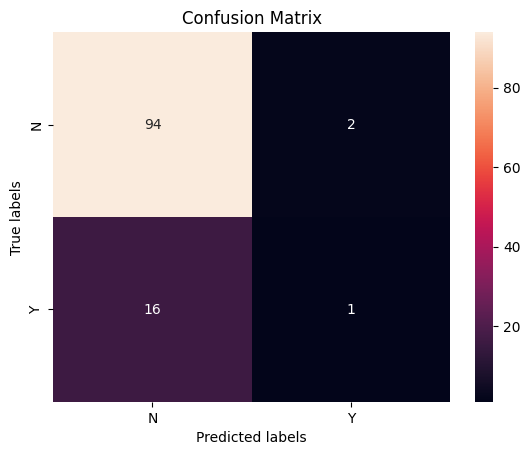

In [15]:
glm = LogisticRegression(solver='liblinear', penalty='l1')
glm.fit(X_train, y_train)
y_pred = glm.predict(X_test)
pretty_confusion(y_test, y_pred)

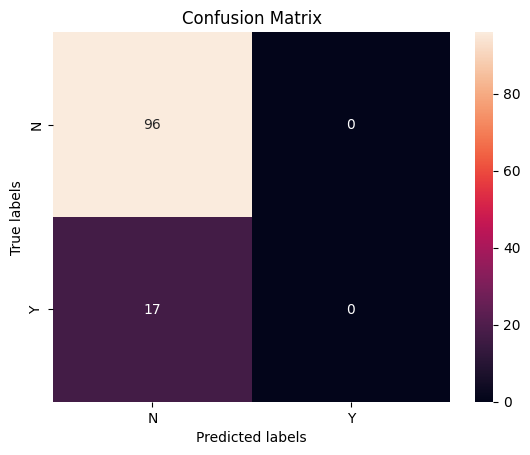

In [16]:
clf = RandomForestClassifier(max_depth=3)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
pretty_confusion(y_test, y_pred)

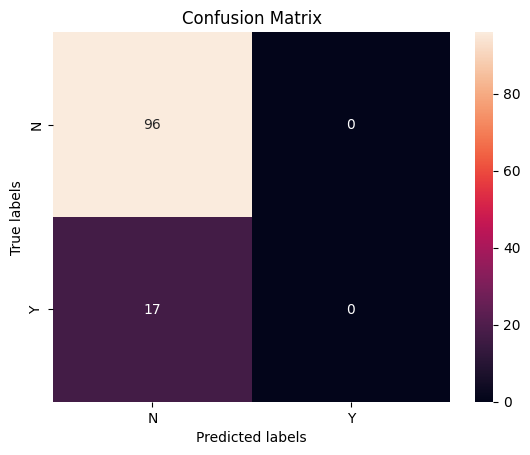

In [17]:
svc = SVC(C=1, kernel='rbf')
svc.fit(X_train, y_train)
y_pred = clf.predict(X_test)
pretty_confusion(y_test, y_pred)

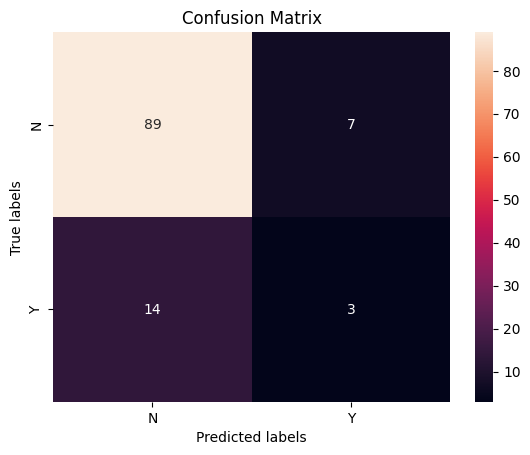

In [18]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
pretty_confusion(y_test, y_pred)

# Trimming the fat (removing features)

It is clear that we are heavily underfitting our models by overloading them with data. Below we will prune most of the columns that show little relation to the target. We will score by using the F-statistic and removing features which are not statistically significant enough. 

In [16]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [17]:
y = teams.WSWin
X = teams.drop(['yearID', 'teamID', 'WSWin'], axis=1)

best_features = SelectKBest(score_func = f_classif, k = 'all')

fit = best_features.fit(X, y)

featureScores = pd.DataFrame(data = fit.scores_,index = list(X.columns),columns = ['ANOVA Score']) 
featureScores = featureScores.sort_values(ascending = False,by = 'ANOVA Score')

/home/zach/.local/lib/python3.8/site-packages/seaborn/matrix.py:213: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` instead.


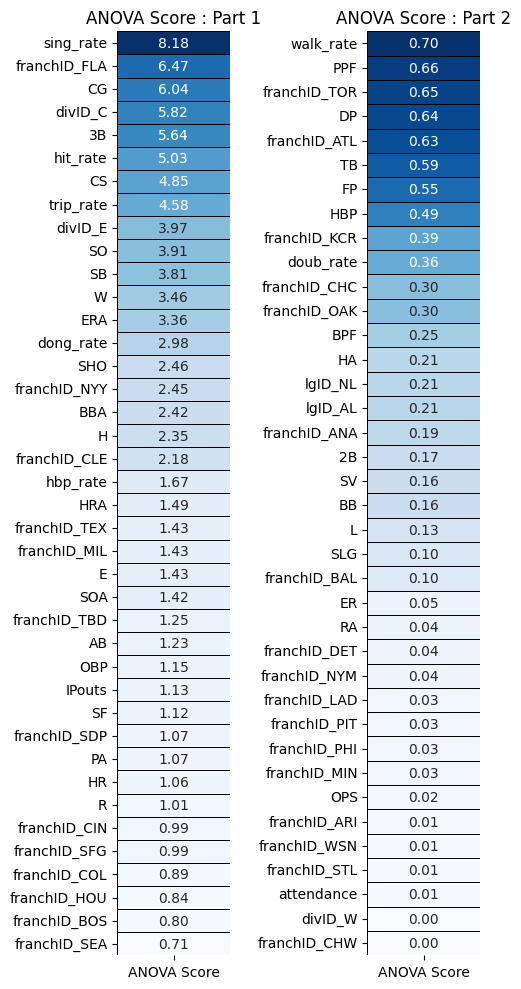

In [18]:
fig,ax = plt.subplots(nrows = 1,ncols = 2,figsize = (5,10))

plt.subplot(1,2,1)
sns.heatmap(featureScores.iloc[:40,:],annot = True,cmap = 'Blues',linewidths = 0.4,linecolor = 'black',cbar = False, fmt = '.2f')
plt.title('ANOVA Score : Part 1')

plt.subplot(1,2,2)
sns.heatmap(featureScores.iloc[40:81],annot = True,cmap = 'Blues',linewidths = 0.4,linecolor = 'black',cbar = False, fmt = '.2f')
plt.title('ANOVA Score : Part 2')

fig.tight_layout(w_pad = 2)

In [126]:
selected = featureScores[featureScores['ANOVA Score'] > 2.44]

In [127]:
X = teams[selected.index]

Okay, now that we have trimmed many of the columns, let us run our models on the new data.

In [128]:
y = (teams.WSWin == 'Y')*1

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=65537)

In [130]:
def model(classifier,X_train,y_train,X_test,y_test):
    
    classifier.fit(X_train,y_train)
    prediction = classifier.predict(X_test)
    cv = RepeatedStratifiedKFold(n_splits = 10,n_repeats = 3,random_state = 1)
    print("Cross Validation Score : ",'{0:.2%}'.format(cross_val_score(classifier,X_train,y_train,cv = cv,scoring = 'roc_auc').mean()))
    print("ROC_AUC Score : ",'{0:.2%}'.format(roc_auc_score(y_test,prediction)))
    plot_roc_curve(classifier, X_test, y_test)
    plt.title('ROC_AUC_Plot')
    plt.show()
    
def model_evaluation(classifier,X_test,y_test):
    
    # Confusion Matrix
    cm = confusion_matrix(y_test,classifier.predict(X_test))
    names = ['True Neg','False Pos','False Neg','True Pos']
    counts = [value for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,counts,percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm,annot = labels,cmap = 'Blues',fmt ='')
    
    # Classification Report
    print(classification_report(y_test,classifier.predict(X_test)))

In [131]:
glm = LogisticRegression(random_state = 65536, C=1, solver='liblinear', penalty='l2')

Cross Validation Score :  61.42%
ROC_AUC Score :  50.00%


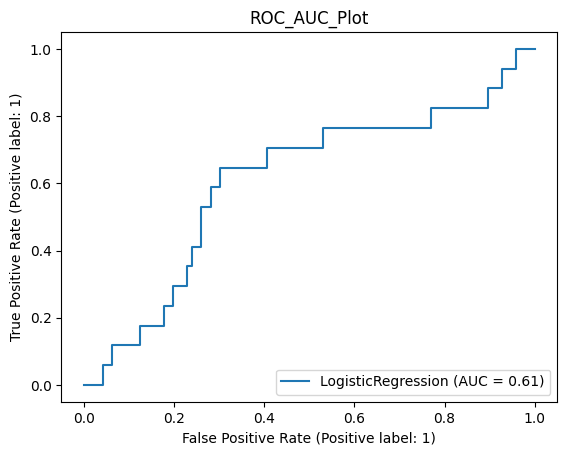

In [132]:
model(glm, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.85      1.00      0.92        96
           1       0.00      0.00      0.00        17

    accuracy                           0.85       113
   macro avg       0.42      0.50      0.46       113
weighted avg       0.72      0.85      0.78       113



/home/zach/.local/lib/python3.8/site-packages/seaborn/matrix.py:213: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` instead.
/home/zach/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/home/zach/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/home/zach/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


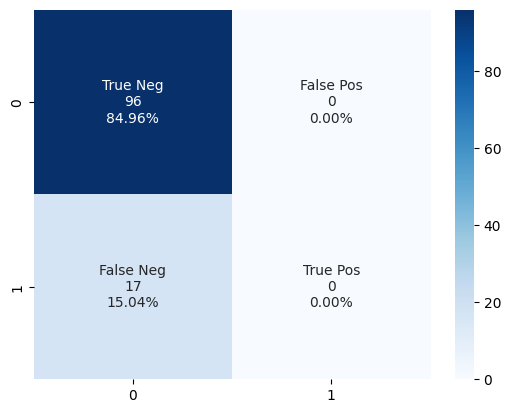

In [133]:
model_evaluation(glm, X_test, y_test)

Clearly we aren't saved yet. Let's try KNN

In [134]:
knn = KNeighborsClassifier(leaf_size = 1, n_neighbors = 1,p = 1)

Cross Validation Score :  43.91%
ROC_AUC Score :  54.47%


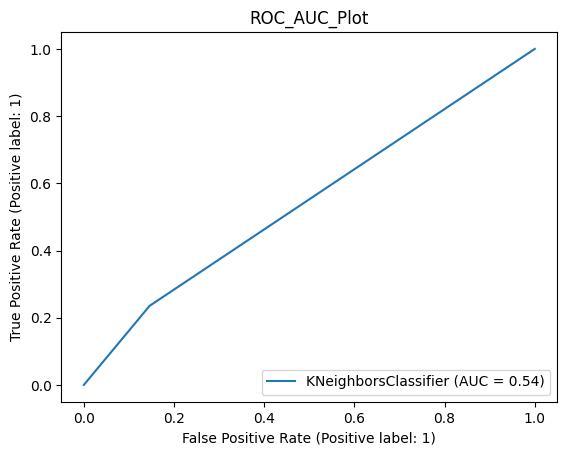

In [135]:
model(knn, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.86      0.85      0.86        96
           1       0.22      0.24      0.23        17

    accuracy                           0.76       113
   macro avg       0.54      0.54      0.54       113
weighted avg       0.77      0.76      0.76       113



/home/zach/.local/lib/python3.8/site-packages/seaborn/matrix.py:213: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` instead.


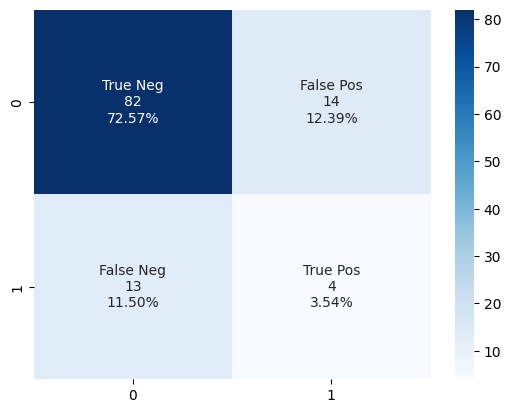

In [136]:
model_evaluation(knn, X_test, y_test)

Cross Validation Score :  57.93%
ROC_AUC Score :  50.00%


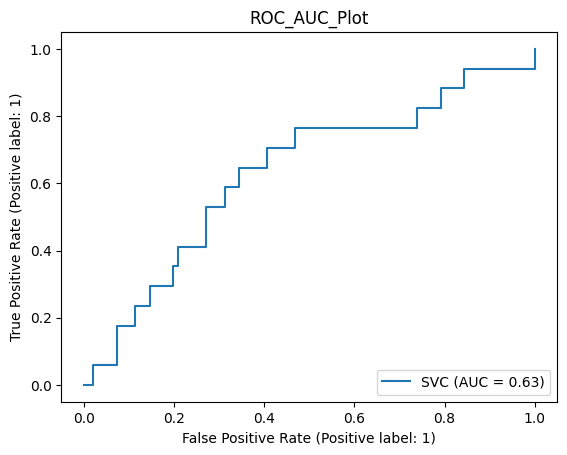

In [137]:
svc = SVC(C=0.1, kernel='linear')
model(svc, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.85      1.00      0.92        96
           1       0.00      0.00      0.00        17

    accuracy                           0.85       113
   macro avg       0.42      0.50      0.46       113
weighted avg       0.72      0.85      0.78       113



/home/zach/.local/lib/python3.8/site-packages/seaborn/matrix.py:213: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` instead.
/home/zach/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/home/zach/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/home/zach/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


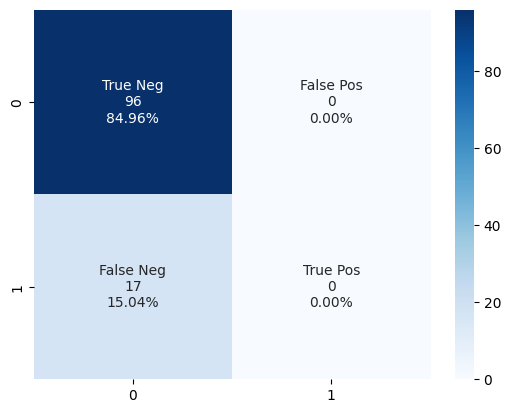

In [139]:
model_evaluation(svc, X_test, y_test)

Cross Validation Score :  55.92%
ROC_AUC Score :  50.00%


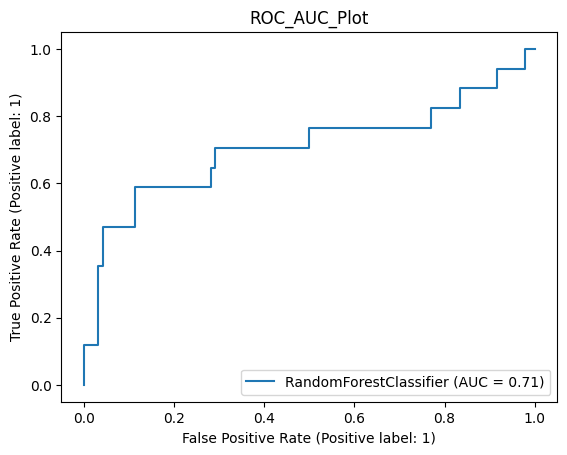

              precision    recall  f1-score   support

           0       0.85      1.00      0.92        96
           1       0.00      0.00      0.00        17

    accuracy                           0.85       113
   macro avg       0.42      0.50      0.46       113
weighted avg       0.72      0.85      0.78       113



/home/zach/.local/lib/python3.8/site-packages/seaborn/matrix.py:213: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` instead.
/home/zach/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/home/zach/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/home/zach/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


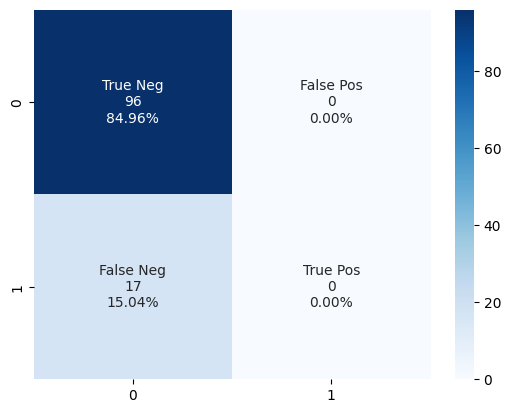

In [140]:
clf = RandomForestClassifier(max_depth=2)
model(clf, X_train, y_train, X_test, y_test)
model_evaluation(clf, X_test, y_test)